In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap streamlit pyspark openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.4 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()  # Click "Choose Files" and select creditcard.csv

import pandas as pd
import io

data = pd.read_csv(io.BytesIO(uploaded['creditcard.csv']))
print(data.head())


Saving creditcard.csv to creditcard.csv
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206

In [3]:
# Check for missing values
print(data.isnull().sum())

# Separate features and target
X = data.drop("Class", axis=1)
y = data["Class"]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:58:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.81      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.940590259035522


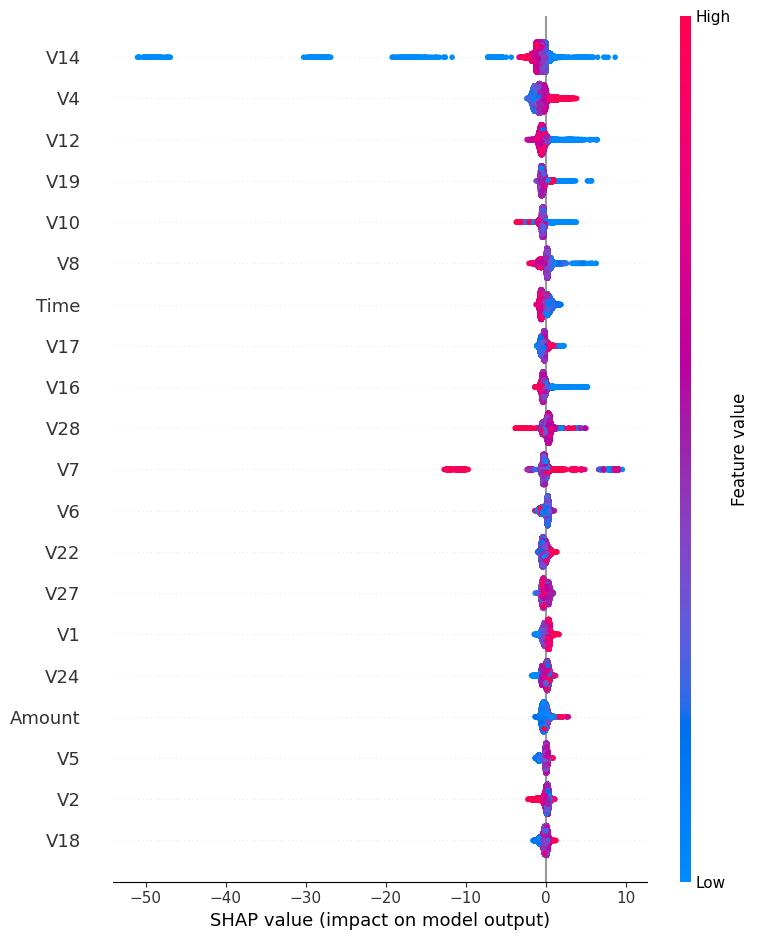

In [5]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


In [6]:
# Flag transactions automatically
threshold = 0.8  # probability threshold
high_risk = X_test[y_prob > threshold]
print("High-risk transactions:")
print(high_risk.head())


High-risk transactions:
            Time         V1        V2         V3        V4         V5  \
43428    41505.0 -16.526507  8.584972 -18.649853  9.505594 -13.793819   
116404   74262.0  -2.250535  2.365755  -2.955491  0.089791  -2.830745   
233654  147645.0   1.915762  1.753538  -2.592348  4.416900   1.504678   
215984  140308.0  -4.861747 -2.722660  -4.656248  2.502005  -2.008346   
77099    56887.0  -0.075483  1.812355  -2.566981  4.127549  -1.628532   

              V6         V7        V8        V9  ...       V20       V21  \
43428  -2.832404 -16.701694  7.517344 -8.507059  ... -1.514923  1.190739   
116404 -0.844462  -0.174062 -0.407138  0.174216  ... -0.486537  0.256560   
233654 -1.279130   0.641565 -0.313370 -1.462187  ... -0.079542 -0.022968   
215984  0.615422  -3.485680  1.878856 -1.116268  ...  0.285559  1.138876   
77099  -0.805895  -3.390135  1.019353 -2.451251  ...  0.338598  0.794372   

             V22       V23       V24       V25       V26       V27       V28  \


In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("FraudDetection").getOrCreate()
df_spark = spark.createDataFrame(data)
df_spark.show(5)


+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                V21|               V22|          

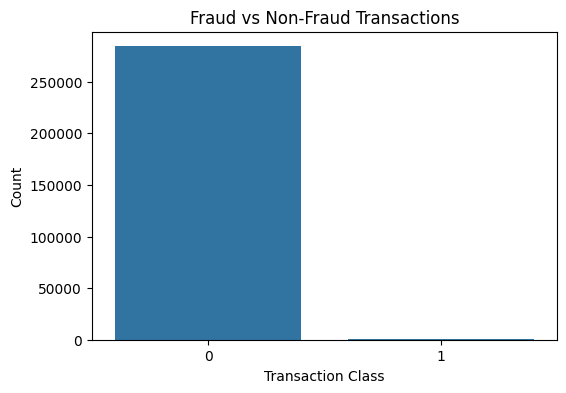

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Transaction Class")
plt.ylabel("Count")
plt.show()


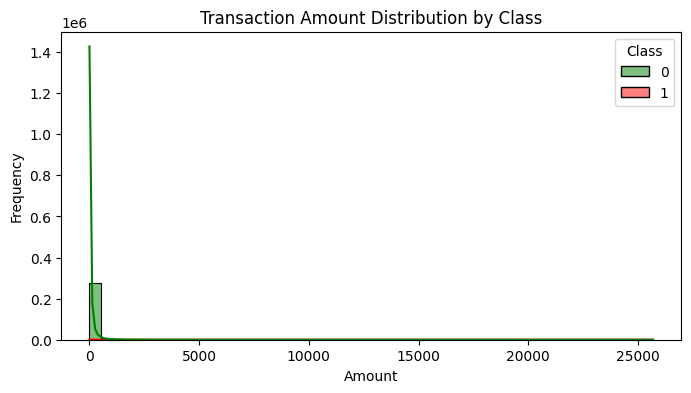

In [17]:
plt.figure(figsize=(8,4))
sns.histplot(data=data, x='Amount', bins=50, hue='Class', kde=True, palette=['green','red'])
plt.title("Transaction Amount Distribution by Class")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()


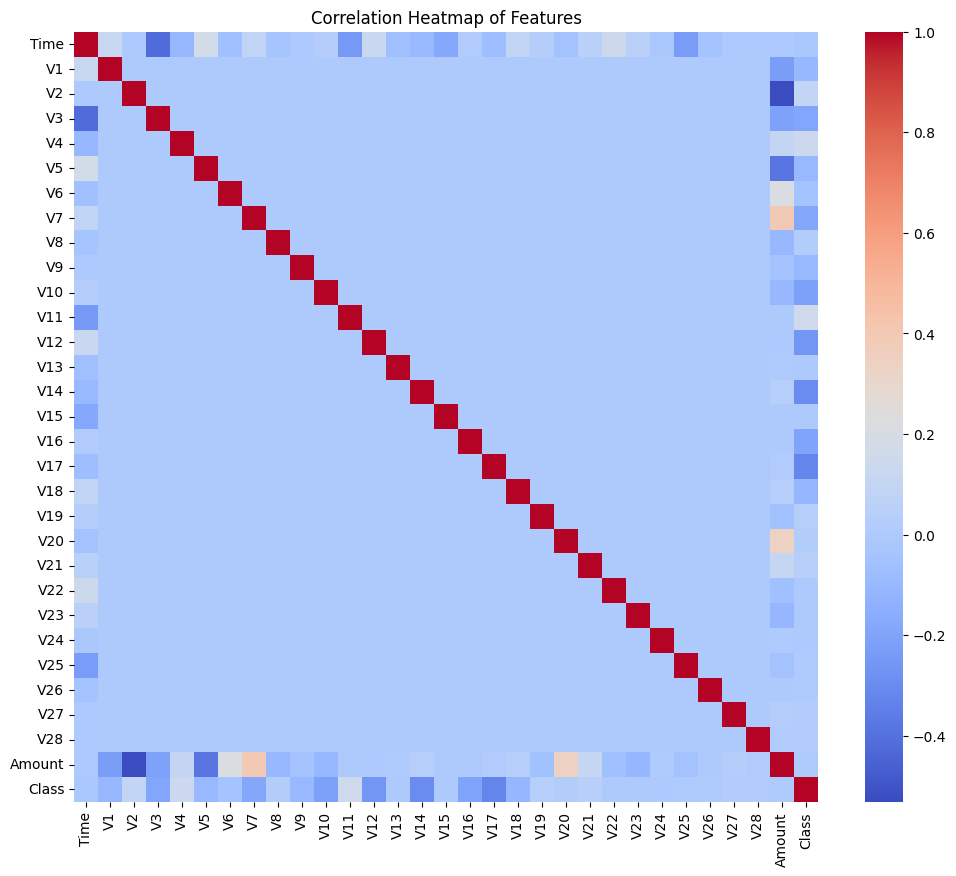

In [18]:
plt.figure(figsize=(12,10))
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Features")
plt.show()


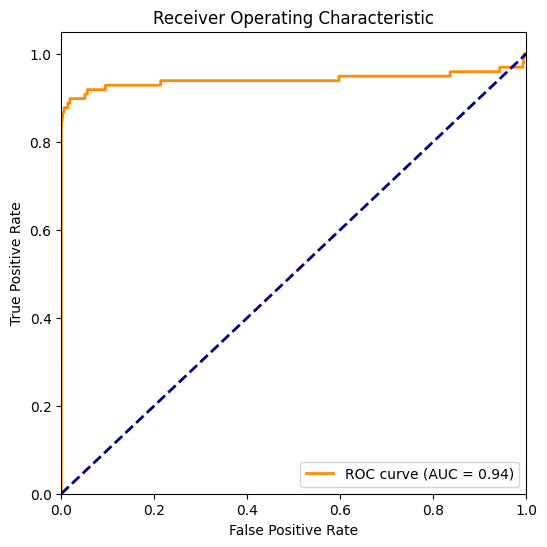

In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


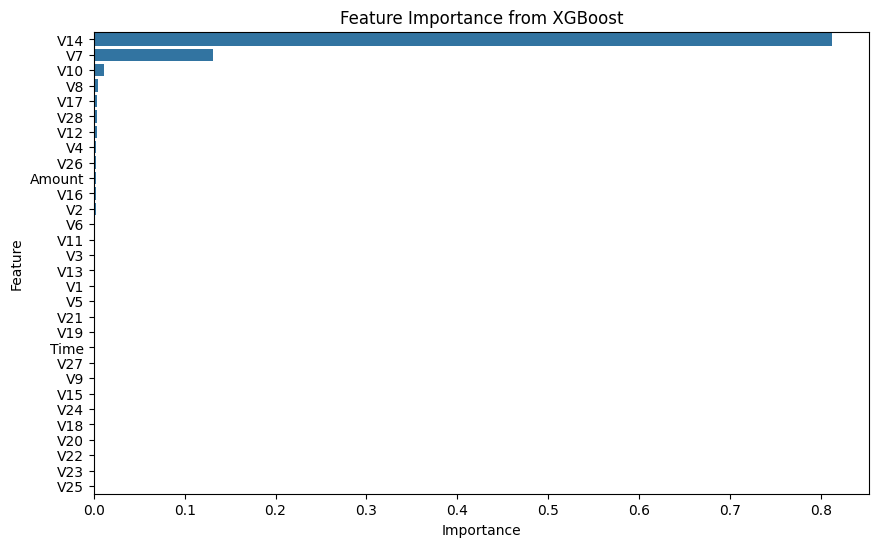

In [20]:
import pandas as pd

# Get feature importance
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title("Feature Importance from XGBoost")
plt.show()
